# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import quandl

In [7]:
from utils import *

In [8]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key
# tickers, prices = get_quandl_sharadar(free=True)
tickers, prices = get_sharadar_train()
prices = prices.query('Set == "train"')

# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

Series to check:

* AKTC

613 days.


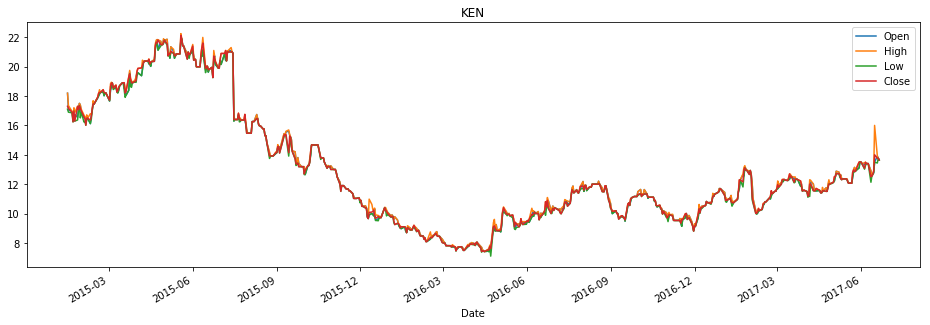

In [12]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [13]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [14]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [15]:
N_ga = 151
f_ga = gaussian(N_ga, std=20.)
f_ga = f_ga / f_ga.sum()

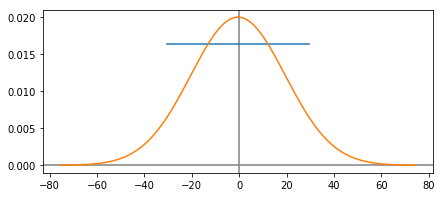

In [16]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Wiener 

In [17]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [18]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

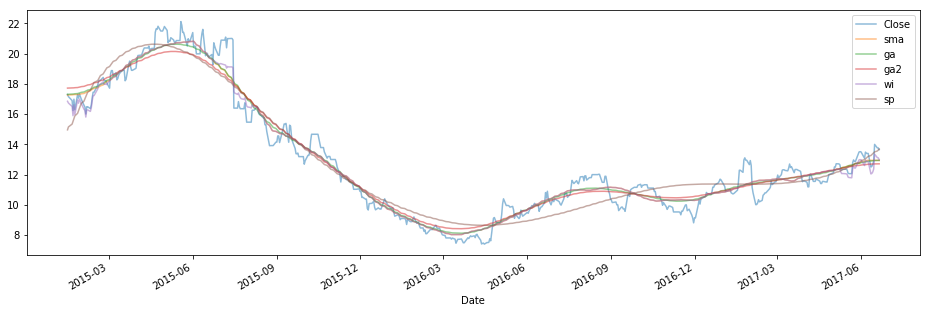

In [19]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(sma=filters.convolve1d(price.Close, f_sma),
                                  ga=filters.convolve1d(price.Close, f_ga),
                                  ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
                                  wi=f_wi(price.Close),
                                  sp=f_sp(price.Close))
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

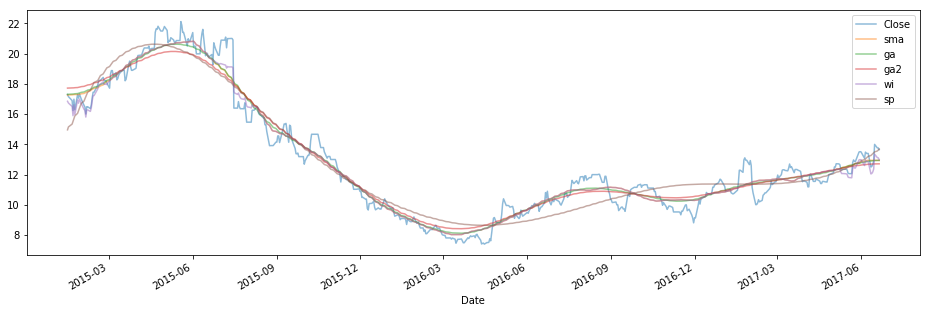

In [20]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [21]:
def smooth_price(df, N=151, std=20.):
    f_ga = gaussian(N_ga, std=std)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [22]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [23]:
results = smooth_price(price)

In [24]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed
Date,,,,,,,,,,
2015-01-15,18.190,18.190,17.100,17.300,41700.0,0.0,17.300,2017-11-01,train,17.313396
2015-01-16,17.050,17.350,16.900,17.160,105300.0,0.0,17.160,2017-11-01,train,17.315795
2015-01-20,16.950,16.950,16.856,16.900,36200.0,0.0,16.900,2017-11-01,train,17.320595
2015-01-21,16.380,16.480,16.240,16.240,30600.0,0.0,16.240,2017-11-01,train,17.327799
2015-01-22,16.340,17.200,16.310,16.990,26300.0,0.0,16.990,2017-11-01,train,17.337385
...,...,...,...,...,...,...,...,...,...,...
2017-06-15,12.770,12.900,12.770,12.900,1100.0,0.0,12.900,2017-11-01,train,12.925138
2017-06-16,13.500,16.000,13.500,14.000,13146.0,0.0,14.000,2017-11-01,train,12.931336
2017-06-19,13.910,13.910,13.440,13.765,1021.0,0.0,13.765,2017-11-01,train,12.936004


In [25]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [26]:
n_changes = min(len(peaks), len(valleys))
assert len(set(np.sign(peaks[:n_changes] - valleys[:n_changes]))) == 1

In [27]:
# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32) * len(results) - 1))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32) * len(results) - 1))

In [28]:
peaks

array([ 81, 397, 612], dtype=int64)

> TO DO: Checks.

In [29]:
results.loc[results.index[peaks], 'Trend'] = 1
results.loc[results.index[valleys], 'Trend'] = -1
results.Trend.fillna(method='bfill', inplace=True)

In [30]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown
Date,,,,,,,,,,,,
2015-01-15,18.190,18.190,17.100,17.300,41700.0,0.0,17.300,2017-11-01,train,17.313396,1.0,NaN
2015-01-16,17.050,17.350,16.900,17.160,105300.0,0.0,17.160,2017-11-01,train,17.315795,1.0,NaN
2015-01-20,16.950,16.950,16.856,16.900,36200.0,0.0,16.900,2017-11-01,train,17.320595,1.0,NaN
2015-01-21,16.380,16.480,16.240,16.240,30600.0,0.0,16.240,2017-11-01,train,17.327799,1.0,NaN
2015-01-22,16.340,17.200,16.310,16.990,26300.0,0.0,16.990,2017-11-01,train,17.337385,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-15,12.770,12.900,12.770,12.900,1100.0,0.0,12.900,2017-11-01,train,12.925138,1.0,NaN
2017-06-16,13.500,16.000,13.500,14.000,13146.0,0.0,14.000,2017-11-01,train,12.931336,1.0,NaN
2017-06-19,13.910,13.910,13.440,13.765,1021.0,0.0,13.765,2017-11-01,train,12.936004,1.0,NaN


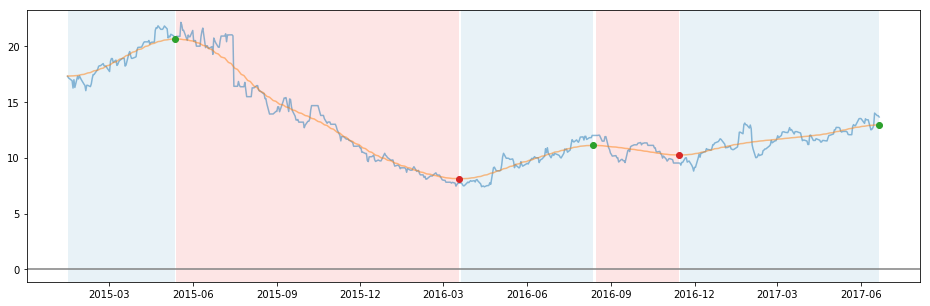

In [31]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [32]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

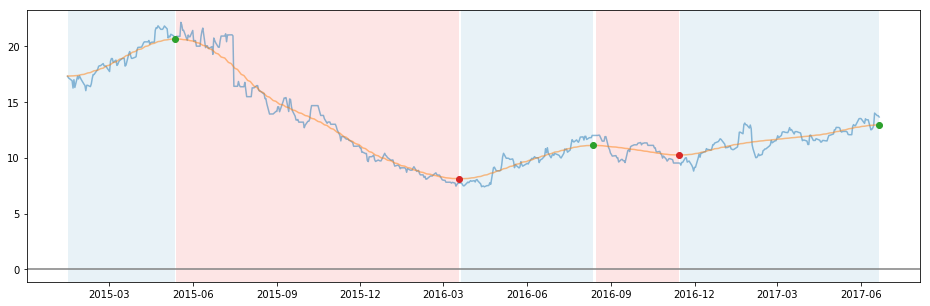

In [33]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [34]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

array([[0.45513866, 0.        ],
       [0.        , 0.54486134]])

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [35]:
breakpoints = np.concatenate((np.zeros(1, dtype=np.int32), peaks + 1, valleys + 1))
breakpoints.sort()
print('Breakpoints:', breakpoints)

Breakpoints: [  0  82 296 398 463 613]


In [36]:
b = 3
trend_start = breakpoints[b - 1]
trend_end = breakpoints[b]
res_b = results[trend_start:trend_end]
res_b

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,,
2016-03-21,7.74,7.74,7.74,7.74,300.0,0.0,7.74,2017-11-01,train,8.124007,1.0,NaN,1.0
2016-03-22,7.70,7.70,7.62,7.62,700.0,0.0,7.62,2017-11-01,train,8.126799,1.0,NaN,1.0
2016-03-23,7.59,7.59,7.49,7.49,600.0,0.0,7.49,2017-11-01,train,8.131417,1.0,NaN,1.0
2016-03-24,7.49,7.49,7.49,7.49,0.0,0.0,7.49,2017-11-01,train,8.137879,1.0,NaN,1.0
2016-03-28,7.74,7.89,7.74,7.82,1300.0,0.0,7.82,2017-11-01,train,8.146177,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-08,11.79,11.80,11.79,11.80,900.0,0.0,11.80,2017-11-01,train,11.096671,1.0,NaN,1.0
2016-08-09,11.80,11.80,11.80,11.80,0.0,0.0,11.80,2017-11-01,train,11.101500,1.0,NaN,1.0
2016-08-10,11.80,11.80,11.80,11.80,800.0,0.0,11.80,2017-11-01,train,11.104737,1.0,NaN,1.0


In [37]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1]
    trend_end = breakpoints[b]
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [38]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,,
2015-01-15,18.190,18.190,17.100,17.300,41700.0,0.0,17.300,2017-11-01,train,17.313396,1.0,0.076595,1.0
2015-01-16,17.050,17.350,16.900,17.160,105300.0,0.0,17.160,2017-11-01,train,17.315795,1.0,0.076595,1.0
2015-01-20,16.950,16.950,16.856,16.900,36200.0,0.0,16.900,2017-11-01,train,17.320595,1.0,0.076595,1.0
2015-01-21,16.380,16.480,16.240,16.240,30600.0,0.0,16.240,2017-11-01,train,17.327799,1.0,0.076595,1.0
2015-01-22,16.340,17.200,16.310,16.990,26300.0,0.0,16.990,2017-11-01,train,17.337385,1.0,0.076595,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-15,12.770,12.900,12.770,12.900,1100.0,0.0,12.900,2017-11-01,train,12.925138,1.0,0.236461,1.0
2017-06-16,13.500,16.000,13.500,14.000,13146.0,0.0,14.000,2017-11-01,train,12.931336,1.0,0.236461,1.0
2017-06-19,13.910,13.910,13.440,13.765,1021.0,0.0,13.765,2017-11-01,train,12.936004,1.0,0.236461,1.0


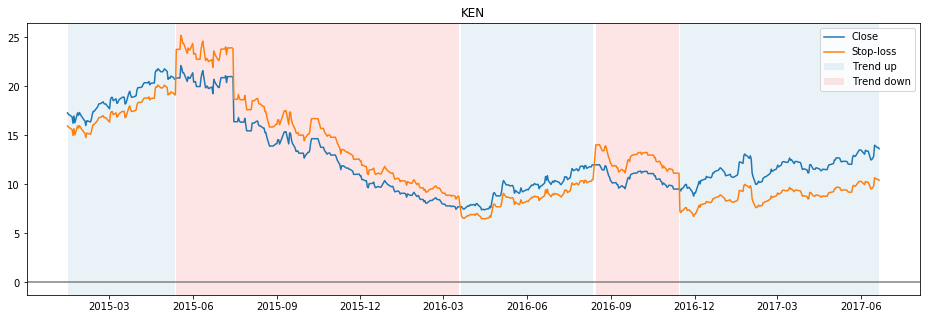

In [39]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

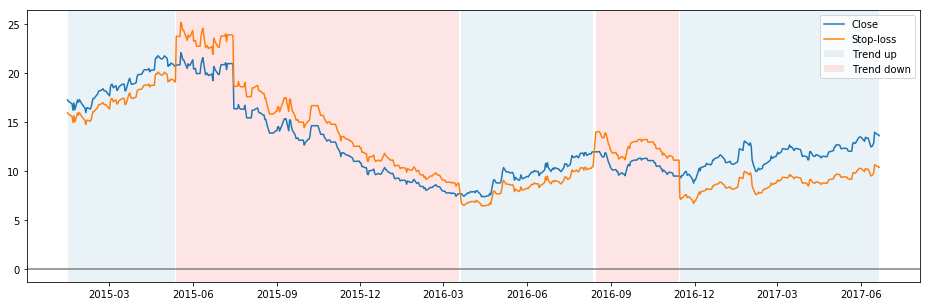

In [42]:
res2 = find_trends(price)
plot_trends(res2)

# Sample...

In [117]:
from utils import *
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')

3437 days.


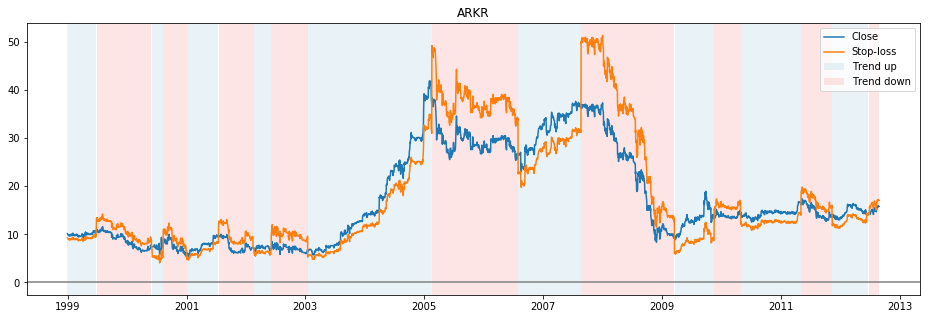

In [139]:
trends = find_trends(price, sd=60.)
plot_trends(trends, ticker)

In [140]:
DataFrame(trends.groupby('n_Trend').Trend.count().describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Trend,30.0,114.566667,136.388311,1.0,2.0,85.5,152.25,526.0


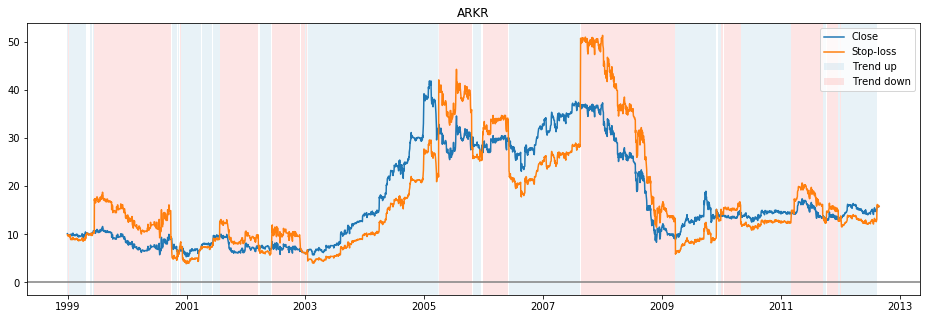

In [138]:
trends2 = find_trends(price, sd=100.)
plot_trends(trends2, ticker)

In [121]:
DataFrame(trends2.groupby('n_Trend').Trend.count().describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Trend,36.0,95.472222,134.020784,1.0,2.0,8.0,162.25,536.0


In [129]:
def summarise_trends(df, sd=20.):
    trends = find_trends(df, sd)
    res = DataFrame(trends.groupby('n_Trend').Trend.count().describe())
    res = res.transpose().assign(sd = sd).set_index('sd')
    
    return res

sds = np.arange(5, 150, step=1)
trends_sds = pd.concat([summarise_trends(price, s) for s in sds], axis=0)

In [130]:
trends_sds

,count,mean,std,min,25%,50%,75%,max
sd,,,,,,,,
5,855.0,4.019883,3.610202,1.0,1.00,3.0,5.00,26.0
6,808.0,4.253713,4.179817,1.0,1.00,3.0,6.00,38.0
7,726.0,4.734160,4.523912,1.0,1.00,3.0,7.00,28.0
8,690.0,4.981159,5.050220,1.0,1.00,3.0,8.00,39.0
9,696.0,4.938218,5.293452,1.0,1.00,3.0,7.00,39.0
...,...,...,...,...,...,...,...,...
145,28.0,122.750000,105.730834,43.0,70.00,92.5,136.25,515.0
146,28.0,122.750000,105.702456,43.0,69.25,92.5,137.00,515.0
147,28.0,122.750000,105.730834,43.0,70.00,92.5,136.25,515.0


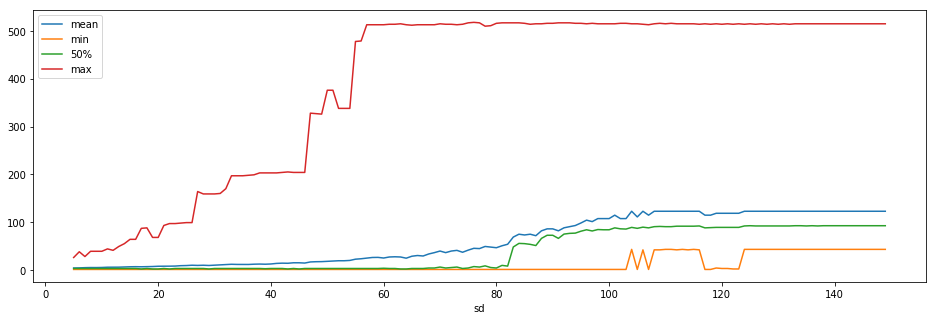

In [131]:
trends_sds[['mean', 'min', '50%', 'max']].plot()

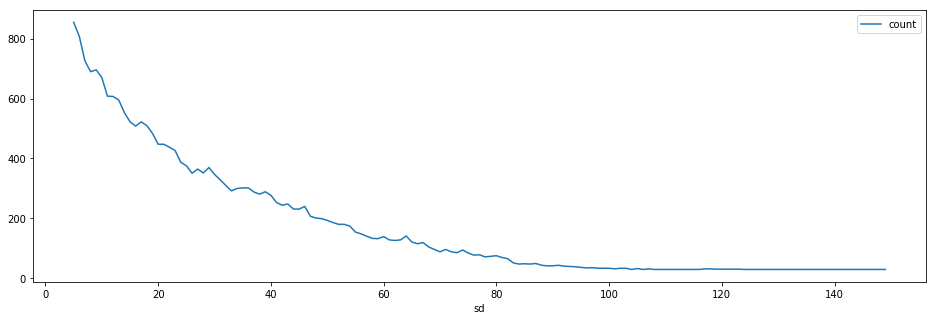

In [132]:
trends_sds[['count']].plot()

# TO DO:

* Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
* Exit by volume (~extreme reduction, bankrupt, ...).